# BRITE Constellation Data Tutorial
---
**Tutorial:** The following script uses data from the BRITE-Constellation public lightcurve archive in python to help users make use of CSA data based on their needs. 

**Mission & Instrument:** BRITE-Constellation, data in this tutorial is taken by the nanosatellite BRITE-Austria

**About the Mission:** The BRITE-Constellation mission consists of fivr BRIght Target Explorer (BRITE) nanosatellites (three are active as of Sept 2023). Each of the following countries built two satellites, Austria, Canada, and Poland. They were launched between February 2013 and August 2014 though BRITE-Montreal was unable to ever launch. The focus of the mission is collect data using optical photometry to learn about stellar struture, evolution, and interactions with the surrounding environment. More information can be found here, https://brite-constellation.at/. 

**System Requirements:** Access to Internet, Python Verison 3.9 or above

**Tutorial Level**: Intermediate

**Installing Libraries**: Remove the hashtage "#" from the following lines to install the packages. You may need to restart your kernel. \
! This step can be skipped if they're already installed !

In [65]:
!python -V

Python 3.9.18


In [66]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install scipy
#!pip install lightkurve
#!pip install astropy
#!pip install tabulate
#!pip install imageio
#!pip install ligo.skymap

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy.time as AS
import lightkurve as lk
import scipy.optimize as spo
from imageio.v2 import imread
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u



### How to download a BRITE lightcurve file

Starting at the CSA Open Data Portal, search for the BRITE Constellation dataset and selecting "Download" will lead to the public archive of lightcurves from the BRITE mission. It can also be accessed through this link, https://brite.camk.edu.pl/pub/index.html.

Selecting "Public lightcurve archive" will cause a list of studied constellations to appear. Choose your desired constellation and either a single file or list of files will drop down. Each of those will contain numerous .dat files for individuals stars within the chosen constellation. 

Download the desired star to study and replace the file name below in the *User Inputs* section. 

#### Example
This tutorial uses the following route, 

Public lighcurve archive > 01 Orion I > 01-Ori-I-2013_DR2 > HD31237_01-Ori-I-2013_BAb_setup3_APa2s5_DR2.dat

We'll be looking at the Orion I constellation, specifically at the star HD31237. 


#### BRITE Wiki
For more information on the data and the constellations, the same webpage has a link titled "BRITE Wiki". This contains relevant and useful information on each of the constellations alongside information in regards to the camera/how the star was captured. 
It can also be reached here, http://brite-wiki.astro.uni.wroc.pl/bwiki/doku.php. 

----

### User Inputs

In [3]:
### USER INPUTS ###

#Name of downloaded .dat file, change this to the file you have saved
FileName = "HD31237_01-Ori-I-2013_BAb_setup3_APa2s5_DR2.dat"

#Name for new txt file to be used for analysis| It will be saved in the same folder as the original lightcurve file
BRITEtxt = 'BRITE_Analysis.txt'

#Parameters for plots
X = 13
Y = 10

#Size of each point on plot
PointSize = 3


----

In [4]:
Path = os.path.realpath(FileName)
DataFrame = pd.read_csv(Path, sep = " ,", on_bad_lines = "skip", engine = "python", header = None)

# Print Info About Dataset / Print Dataset Header
print ("Header Information")
print (pd.DataFrame(DataFrame.iloc[:37]).to_markdown())

print ()
print ("Data Information")
print (pd.DataFrame(DataFrame.iloc[37:46]).to_markdown())
print ()
# Extract name of star
StarInfo = DataFrame.iloc[6]
StarInfo['new'] = StarInfo.str.split(',').str[0]   
for i in ((np.array(StarInfo['new']))):
    s1 = slice(12, len(i))
    StarName = i[s1]
print ("The name of the star is", StarName)
#Extract RA (Right Acension) and DEC (Declination) of the star (also known as the celestial coordinates of the star)
RA_Info = DataFrame.iloc[8]
DEC_Info = DataFrame.iloc[9]

RA_Info['new'] = RA_Info.str.split('/').str[0] 
for i in (np.array(RA_Info['new'])):
    s1 = slice(13, len(i))
    RA = float(i[s1])

DEC_Info['new'] = DEC_Info.str.split('/').str[0] 
for i in (np.array(DEC_Info['new'])):
    s1 = slice(13, len(i))
    DEC = float(i[s1])
print ("Its celestial coordinates are RA = ", RA,"DEC =", DEC ," in degrees")

Header Information
|    | 0                                                                                                                                           |
|---:|:--------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | c start header ----------------------------------------------------------------------------                                                 |
|  1 | c OFilName= HD31237_01-Ori-I-2013_BAb_setup3_APa2s5_DR2.dat       / file name after reformatting                                            |
|  2 | c IFilName= 07_HD31237.dat       / input file name                                                                                          |
|  3 | c IFilSetN= setup3     /setup directory name                                                                                                |
|  4 | c IFilSetF= Setup_131201_150541_26ba.xml     /setup file name                   

In [5]:
# Filter file and only save data as a text file for analysis
NewDF = DataFrame.to_csv(BRITEtxt, sep = '\t', index = False)

OpenFile = open(BRITEtxt).readlines()
DelLine = open(BRITEtxt, 'w').writelines(OpenFile[47:])


# Sort the data into their own lists
file = np.loadtxt(os.path.realpath(BRITEtxt))
DATA = pd.DataFrame(file) #Use dataframe for efficiency

HJD = DATA.loc[:,0]   #Helioentric Julian Date at start of exposure
FLUX = DATA.loc[:,1]  #Flux of the star [ADU/s]
XCEN = DATA.loc[:,2]  #Profile centre of gravity with respect to raster origin - x coords
YCEN = DATA.loc[:,3]  #Profile centre of gravity with respect to raster origin - y coords
Temp = DATA.loc[:,4]  #Temperature of the CCD Camera [C]
JD = DATA.loc[:,5]    #Julian Date at start of exposure
FLAG = DATA.loc[:,6]  # 0 if numerical Aperture extends raster borders 1 if fully rendered 

## Each of these are lists which can easily be used for a variety of analysis

#### Terminology 
**Celestial Coordinates**: Our coordinate system of longitude and latitude is Earth-centric (also called geocentric) and therefore can't be applied to stars or planets. Instead a celestial coordinate system has been developed that uses *right ascension (RA)* in place of longitude and *declination (DEC)* in place of latitude.  
  
  \
**Julian Dates and Heliocentric Julian Dates**: An value assigned to a day that ranges between the start of the Julian Period to the present. This is used as a unit of time measurment for long periods of time due commonly used in astroonomy due to the fact that processes in space (e.g. the growth of a planet) take place over very long periods of time. It's composed of 6 integers and can be followed by decimals if time is included as well. Different variants exist but follow the same principle. This dataset includes the variant called "Heliocentric Julian Date" which is the Julian Date corrected with the Sun as the frame of reference. This provides a more accurate picture of the duration especially when observing objects far from Earth. 

  \
**Flux**: Flux is the change in emitted energy or luminoisty of a star over time. The units used in this dataset is ADU/seconds. ADU stands for Analog Digital Unit and is used by CCD cameras. A CCD camera converts the analog voltage in each pixel/dector to a value and the sum is the energy detected by the camera as a whole.

  \
**Raster Origin**: A raster is the given dimensions of an image (the CCD camera used in this dataset is 32 X 32 pixels). The raster origin is located at the centre of an image. The centre of gravity for a star is at its centre so in this case it's synonymous to the location/centre of the star.

  \
**Flag**: The numerical aperature (NA) is the largest angle that the camera can receive incoming light. If it extends past the raster borders then it means the camera has taken in more light than the processor can handle thus resulting in a loss in information. If it's fully rendered then all the information has been collected with minimal loss. This list can be used to filter the data to ensure only full rendered data are used. 

### Plot Celestial Coordinates

-0.31480906345220194
3.5487391214891715 -0.31480906345220194
2.734446185690415
3.548739121489171


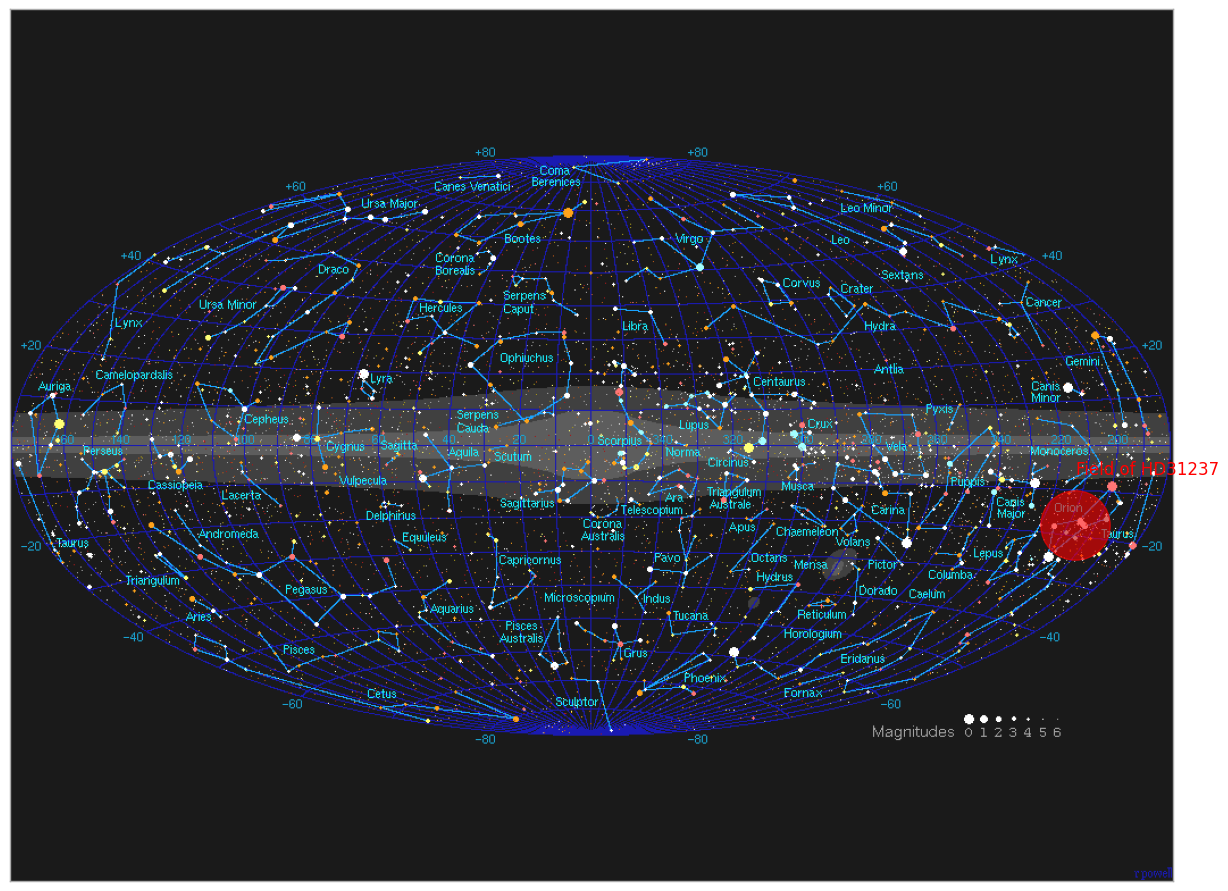

In [46]:
url =  "http://www.atlasoftheuniverse.com/galchart.gif"

RA_RAD = RA * (np.pi)/180
DEC_RAD = DEC * (np.pi)/180

c_star = SkyCoord(RA, DEC, unit = 'deg')

def convert_coords (x):
    X = 0
    if x > np.pi:
        X = -1*((x % np.pi) - np.pi)
    else:
        X = -1*x
    return (X)

img = imread(url)
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(img, alpha = 0.9)

ax2 = fig.add_subplot(projection = "aitoff")


# NEW RADIANS 
gal_rad = float(c_star.galactic.l.deg) * (np.pi)/180
gal_dec = float(c_star.galactic.b.deg) * (np.pi)/180

new_ra = convert_coords(gal_rad)
new_dec =  convert_coords(gal_dec)
print (gal_dec)
# Actual needed coordinates

ax2.plot(new_ra, gal_dec, marker = 'o', markersize = 50, color = 'red', alpha = 0.6)
ax2.text(new_ra - 0.1, gal_dec + 0.2, "Field of " + StarName, color = "red")
print (c_star.galactic.l.rad, c_star.galactic.b.rad)
print (new_ra)
print (gal_rad)

# TEST COORDS
#ax2.plot(1, 1, marker = 'o', color = 'g')
#ax2.plot(0, 0, marker = 'o', color = 'g')
#ax2.plot(0, 1, marker = 'o', color = 'g')
#ax2.plot(0, 1, marker = 'o', color = 'g')

plt.axis("off")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [47]:
#### RETICLE FUNCTION
def reticle(inner=0.5, outer=5.0, angle=0.0, which='lrtb'):
    """Create a reticle or crosshairs marker.

    Parameters
    ----------
    inner : float
        Distance from the origin to the inside of the crosshairs.
    outer : float
        Distance from the origin to the outside of the crosshairs.
    angle : float
        Rotation in degrees; 0 for a '+' orientation and 45 for 'x'.

    Returns
    -------
    path : `matplotlib.path.Path`
        The new marker path, suitable for passing to Matplotlib functions
        (e.g., `plt.plot(..., marker=reticle())`)

    Examples
    --------
    .. plot::
       :context: reset
       :include-source:
       :align: center

        from matplotlib import pyplot as plt
        from ligo.skymap.plot.marker import reticle

        markers = [reticle(inner=0),
                   reticle(which='lt'),
                   reticle(which='lt', angle=45)]

        fig, ax = plt.subplots(figsize=(6, 2))
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-0.5, 0.5)
        for x, marker in enumerate(markers):
            ax.plot(x, 0, markersize=20, markeredgewidth=2, marker=marker)

    """
    angle = np.deg2rad(angle)
    x = np.cos(angle)
    y = np.sin(angle)
    rotation = [[x, y], [-y, x]]
    vertdict = {'l': [-1, 0], 'r': [1, 0], 'b': [0, -1], 't': [0, 1]}
    verts = [vertdict[direction] for direction in which]
    codes = [Path.MOVETO, Path.LINETO] * len(verts)
    verts = np.dot(verts, rotation)
    verts = np.swapaxes([inner * verts, outer * verts], 0, 1).reshape(-1, 2)
    return Path(verts, codes)

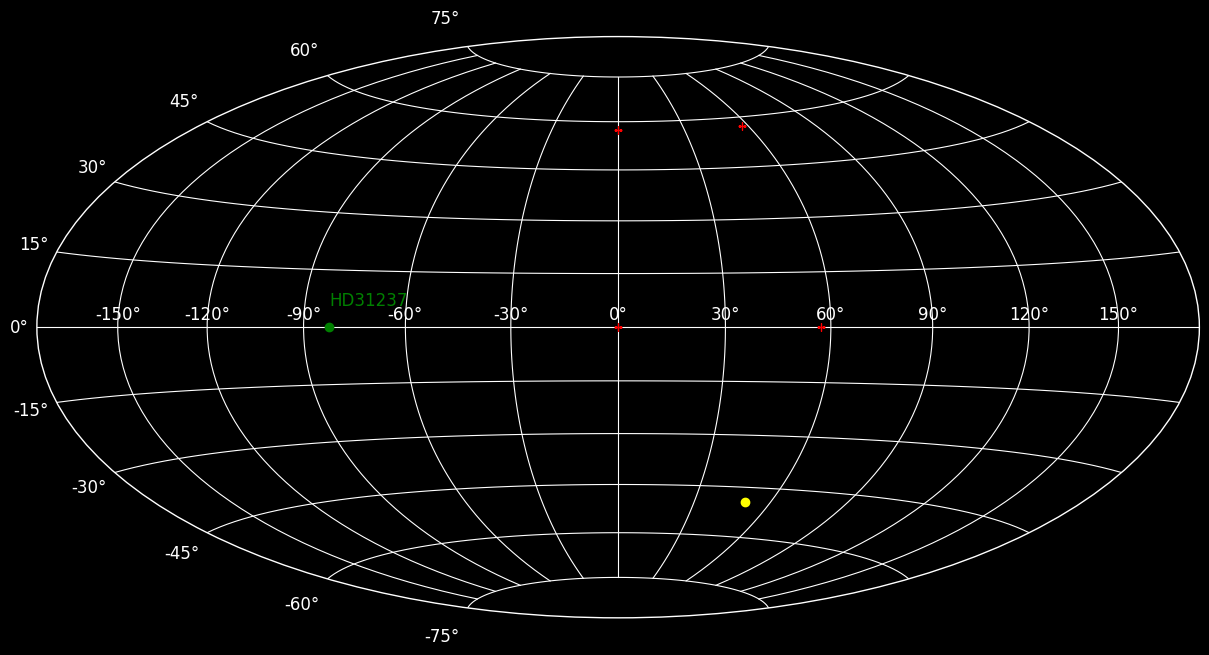

In [48]:
from matplotlib.path import Path

c_sun = SkyCoord("03h49m41.9s","04d0.26m")

plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
fig.delaxes(ax)
ax3 = fig.add_subplot(111, projection = "hammer")

# TEST COORDINATES
ax3.plot(1, 1, marker = reticle(), color = 'red')
ax3.plot(1, 0, marker = reticle(), color = 'red')
ax3.plot(0, 1, marker = reticle(), color = 'red')
ax3.plot(0, 0, marker = reticle(), color = 'red')

# Actual important guy 
ax3.plot(convert_coords(RA_RAD), 0, marker = 'o', color = 'green')
ax3.text(convert_coords(RA_RAD), convert_coords(DEC_RAD) + 0.1, StarName, color = "green")
ax3.plot((c_sun.ra), c_sun.dec, marker = 'o', color = 'yellow')

### Basic Analysis I: Star Location With Respect to Raster Origin

Let's create a plot that shows the location of the star with respect to the center of the camera.

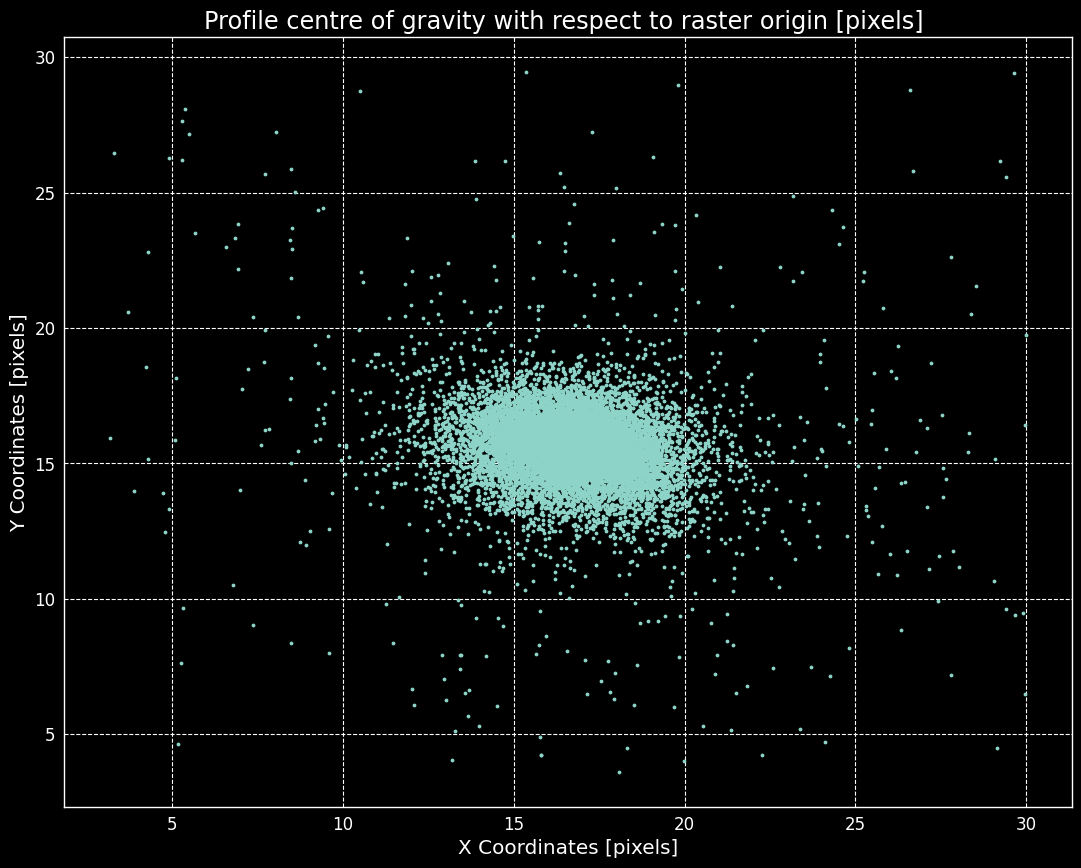

In [49]:
fig, ax = plt.subplots(figsize = (X, Y))
plt.title("Profile centre of gravity with respect to raster origin [pixels] ")
plt.xlabel("X Coordinates [pixels]")
plt.ylabel("Y Coordinates [pixels]")
plt.grid (visible = True, linestyle = "--")
plt.scatter(XCEN, YCEN, s = PointSize)
plt.show()


This plot shows the location or centre of the star relative to where the camera's centre is. As expected the star is centred for most of the experiment with a few outliers. Using this, we can filter out the data that is not centred. 

### Basic Analysis II: Plot CCD Temperature Over Time
We can plot the temperature of the CCD camera over time using the Heliocentric Julian Date.

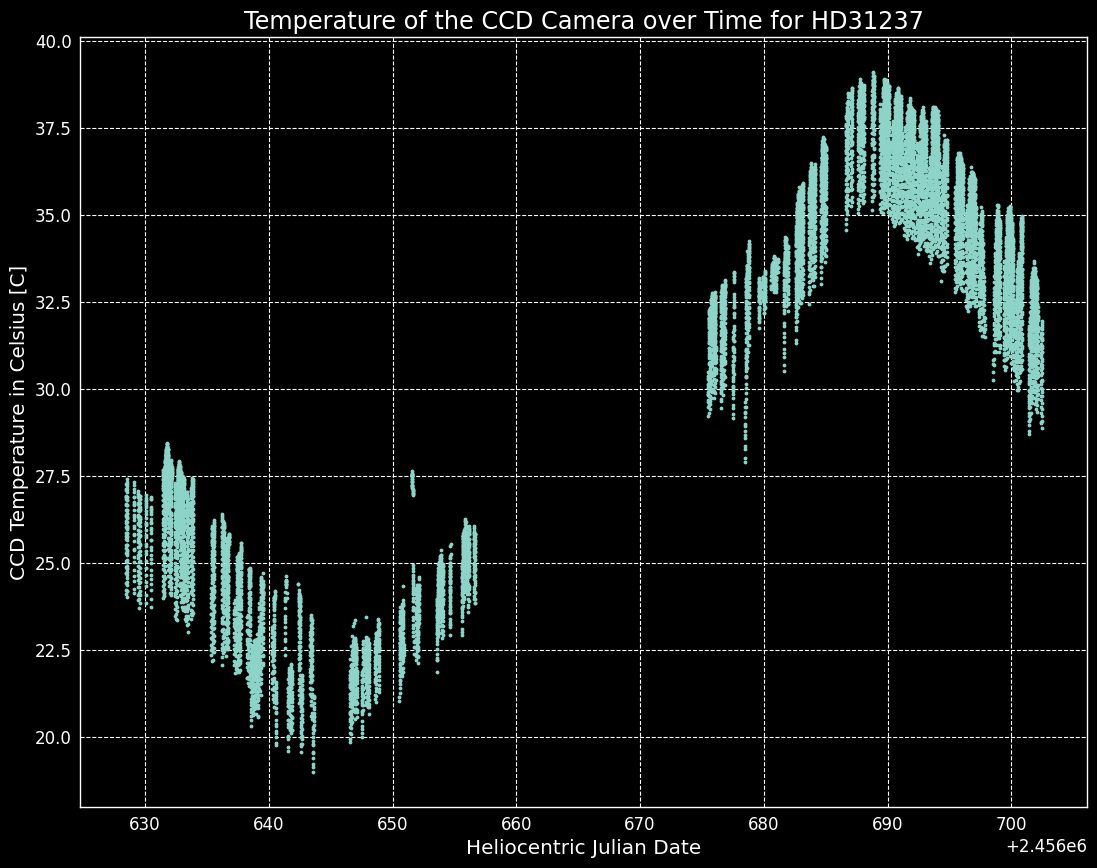

In [50]:
fig, ax = plt.subplots(figsize = (X, Y))
plt.title ("Temperature of the CCD Camera over Time for " + StarName)
plt.xlabel ("Heliocentric Julian Date")
plt.ylabel ("CCD Temperature in Celsius [C]")
plt.grid(visible = True, linestyle = "--")
plt.scatter(HJD, Temp, s = PointSize)
plt.show()


The oscillations in the temperature indicate that the energy emitted from the star is periodically impeded by some other object. Further analyses, as done below, can indicate as to what kind of object it may be. 

### Basic Analysis III: Flux of the Star over Time
Finally, we can the plot the flux of the star. Oscillations seen can be used as evidence for passing dust, clouds or even exoplanets!

In [51]:
### USER INPUTS ###

# Adjust parameters of the figure size
X1 = 12
Y1 = 6

# Adjust the size of each point
PointSize1 = 5

# Here, using different parameters since the plots lend themselves better to a rectangular shape longer on the horizontal

We can create two different kinds of plots. One is Flux against Time (as given in the raw data) and the other is Magnitude vs Time (which we need to calculate). Both plots provide similar results and are used for the same purpose. Which one is used is dependent on preference and the nature of the experiment. 

This tutorial will show both. 

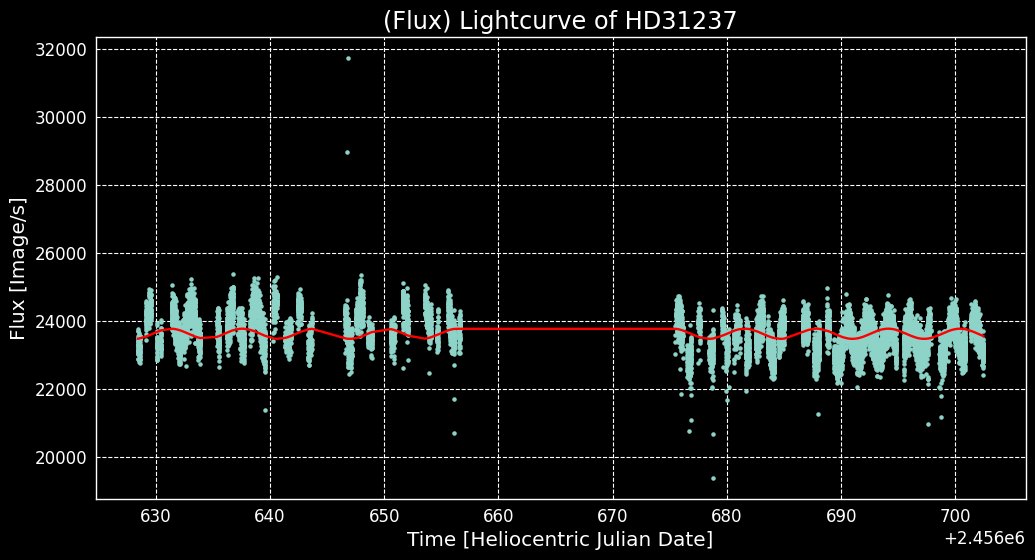

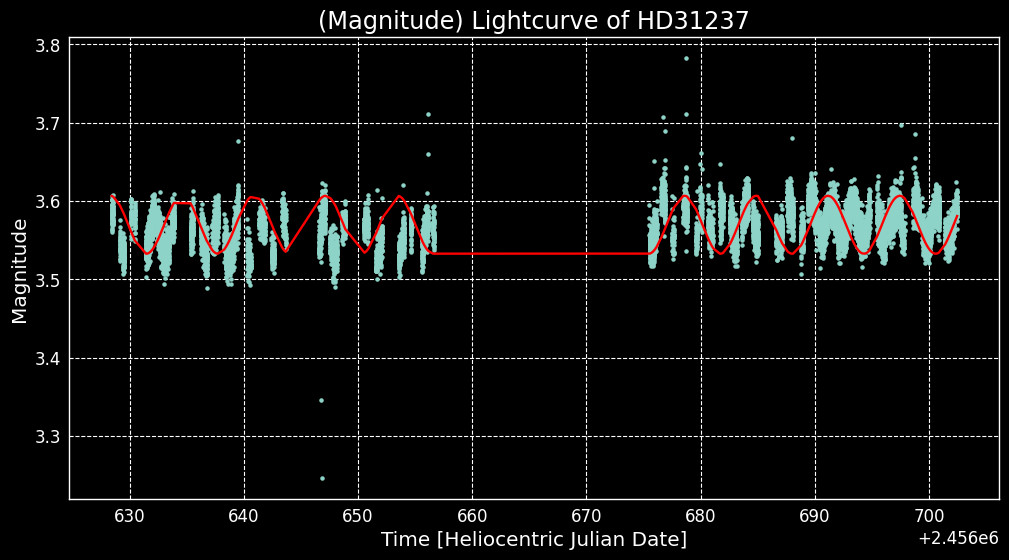

Start Date of Observation: 2013-12-01 22:25:26.198
End Date of Observation: 2014-02-13 22:44:04.733


In [52]:

# Calculate the magnitude of brightness
MAG = -2.5*np.log10(np.array(FLUX)) + 14.5 # The equation is Magnitude = -2.5log_10 (Flux) + 14.5 | More information can be found in the BRITE Cookbook (more info at the end)

# Flux Graph
fig, ax = plt.subplots(figsize = (X1, Y1))
plt.title ("(Flux) Lightcurve of " + StarName)
plt.xlabel ("Time [Heliocentric Julian Date]")
plt.ylabel ("Flux [Image/s]")
plt.grid(visible = True, linestyle = "--")
plt.scatter(HJD, FLUX, s = PointSize1)


# Create a trendline of the data using a sine function
def model_func (x, a, b, c, d):
    return (a*(np.sin(b*(x - c))+d))

popt, pcov = spo.curve_fit(model_func, HJD, FLUX)
plt.plot(HJD, model_func(HJD, popt[0], popt[1], popt[2], popt[3]), color = 'r')
plt.show()

#Magnitude Graph
fig, ax = plt.subplots(figsize = (X1, Y1))
plt.title ("(Magnitude) Lightcurve of " + StarName)
plt.xlabel ("Time [Heliocentric Julian Date]")
plt.ylabel ("Magnitude")
plt.grid(visible = True, linestyle = "--")
plt.scatter(HJD, MAG, s = PointSize1)

popt, pcov = spo.curve_fit(model_func, HJD, MAG)
plt.plot(HJD, model_func(HJD, popt[0], popt[1], popt[2], popt[3]), color = 'r')
plt.show()

# Print the start and end date of observation
# Converting from heliocentric julian date to international standard date (YYYY/MM/DD)
t_start = AS.Time(float(HJD[0]), format = "jd")
t_end = AS.Time(float(HJD[12110]), format = "jd")
print ("Start Date of Observation:", t_start.to_value("iso"))
print ("End Date of Observation:", t_end.to_value("iso"))

These graphs show the rise and fall of flux / the magnitude of the brightness over the course of ~3 months. A trendline in red clearly shows the oscillations. Now we'll filter that data to remove any extreme outliers. 

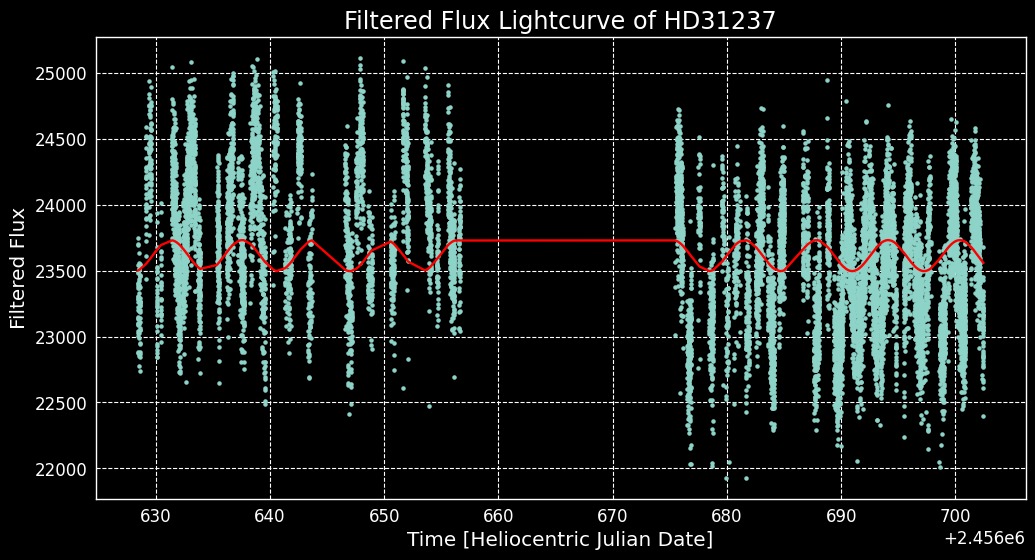

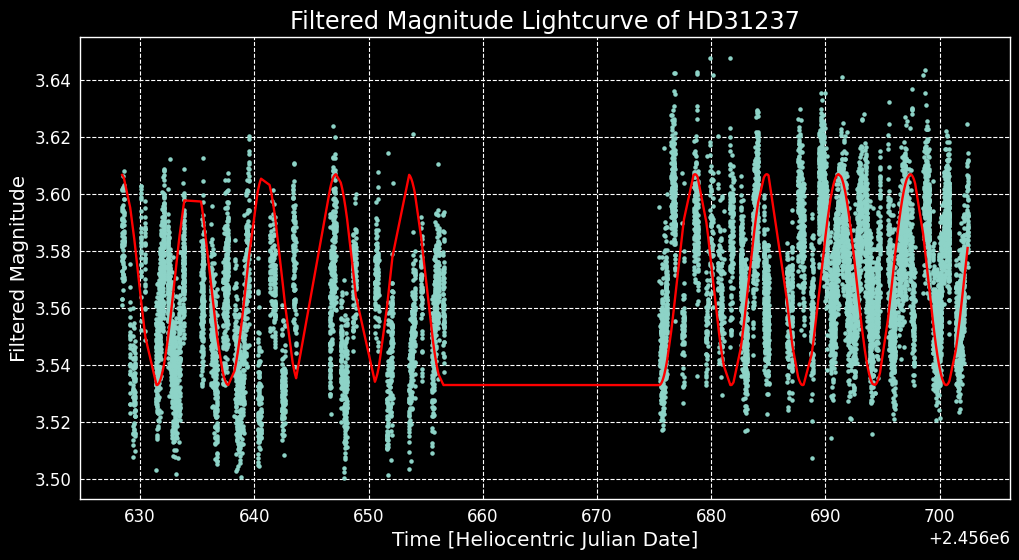

In [53]:
# Filter the data to remove extreme outliers (magnitude)

# Filter magnitude
POP = [] # holds the values of all the outliers within magnitude
index = 0
for i in MAG:
    if i > 3.650:
        POP.append(index)
    elif i < 3.5:
        POP.append(index)
    index += 1

NEW_MAG = np.delete(MAG, POP) #New list with filtered magnitude
NEW_HJD = np.delete(np.array(HJD), POP) #New list with the coresponding days removed

NEW_FLUX =  np.delete(np.array(FLUX), POP) #New list with filtered flux

#PLot new flux
fig, ax = plt.subplots(figsize = (X1, Y1))
plt.title ("Filtered Flux Lightcurve of " + StarName)
plt.xlabel ("Time [Heliocentric Julian Date]")
plt.ylabel ("Filtered Flux")
plt.grid(visible = True, linestyle = "--")
plt.scatter(NEW_HJD, NEW_FLUX, s = PointSize1)

popt, pcov = spo.curve_fit(model_func, NEW_HJD, NEW_FLUX)
plt.plot(NEW_HJD, model_func(NEW_HJD, popt[0], popt[1], popt[2], popt[3]), color = 'r')
plt.show()

# Plot new magnitude
fig, ax = plt.subplots(figsize = (X1, Y1))
plt.title ("Filtered Magnitude Lightcurve of " + StarName)
plt.xlabel ("Time [Heliocentric Julian Date]")
plt.ylabel ("Filtered Magnitude")
plt.grid(visible = True, linestyle = "--")
plt.scatter(NEW_HJD, NEW_MAG, s = PointSize1)


popt, pcov = spo.curve_fit(model_func, NEW_HJD, NEW_MAG)
plt.plot(NEW_HJD, model_func(NEW_HJD, popt[0], popt[1], popt[2], popt[3]), color = 'r')
plt.show()

As evident in the two graphs above, the flux and magnitude graphs show the same pattern but the magnitude graph allows us to see the oscillations more clearly on a scale more understandable for us. Astronomers often used the magntiude for this purpose but the following section will show how we can make use of the flux graph.  

Using this new set of flux, a periodogram (specifically a Lomb Scargle periodogram, developed by Dr.Nick. R. Lomb and Dr. Jeffery.D. Scargle) can be made to determine the maximum period of the star's orbit. This process is better done with flux instead of magnitude.

**Periodogram**: A mathematical algorithm used as an alternative to Fourier analysis to analyze unevenly spaced time series data for osciallations. Its uses range from astrophysics to biological rhythms and medical studies.\
More information can be found here, https://www.collimator.ai/reference-guides/what-is-a-lomb-scargle-periodogram 

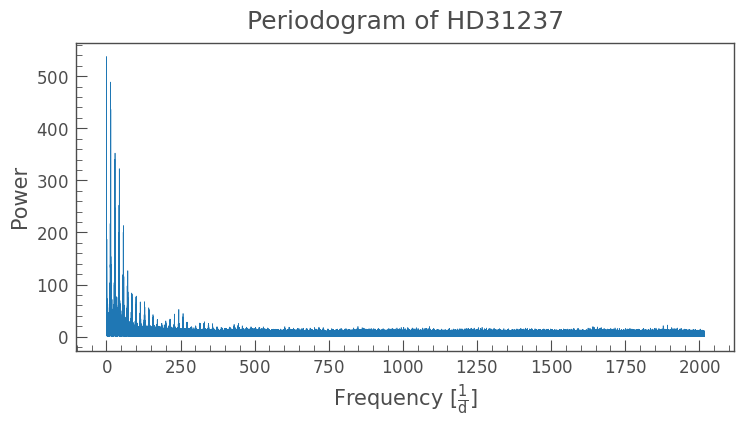

The maximum period is 1.8503236500080675 d


In [54]:
# Create a periodogram and find the max period
lc = lk.LightCurve(time = NEW_HJD, flux = NEW_FLUX)
lc.to_periodogram().plot(title = "Periodogram of " + StarName, color = 'tab:blue')
plt.show()

period = lc.to_periodogram().period_at_max_power
print ("The maximum period is", period)
# the unit 'd' refers to days

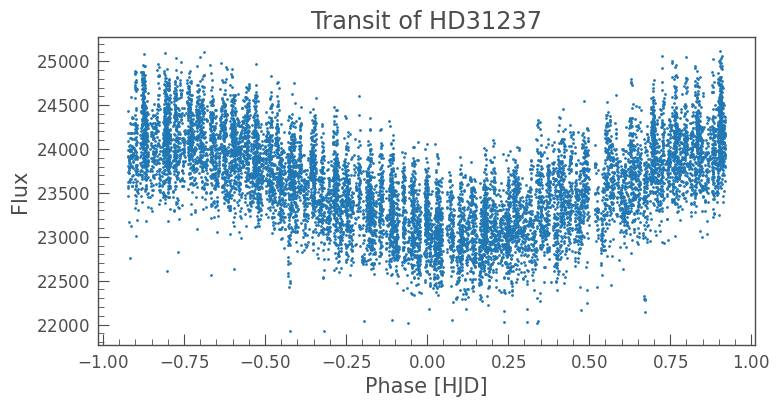

In [55]:
# Create a phase vs flux model to determine what kind of object is orbiting the star using the transit method
lc.fold(period).scatter(xlabel = "Phase [HJD]", color = "tab:blue")
plt.title("Transit of " + StarName)

popt, pcov = spo.curve_fit(model_func, HJD, FLUX)
#plt.plot(HJD, model_func(HJD, popt[0], popt[1], popt[2], popt[3]), color = 'r')
plt.show()


This is a light curve with the folded periodogram made in the previous cell. Using this, we can use the *transit method* and notice that the dip in flux indicates a passing or orbiting object. 

 This method is often used to detect exoplanets. Due to the slight dip seen here, most likely there are dust clouds around this star.  \
 To see what the graph may look like for an exoplanet, the ESA has a great video demonstrating that: https://www.youtube.com/watch?v=xNeRqbw18Jk (note: the video has no audio)

For more information on the transit method/exoplanet discovery: \
CSA: https://www.asc-csa.gc.ca/eng/astronomy/beyond-our-solar-system/detecting-exoplanets.asp \
NASA: https://exoplanets.nasa.gov/faq/31/whats-a-transit/ 

------

### Additonal Information

For more information and ideas on working with BRITE data, there's the BRITE Cookbook produced by Andrezj Pigulski and the BRITE Team. It shows more ways to work with the data and goes into detail on the collection and analysis of data.  https://www.pta.edu.pl/pliki/proc/vol8/v8p175.pdf

For a deeper overview of the mission, the BRTIE Team has a paper detailing the development and results of the mission. https://iopscience.iop.org/article/10.1086/677236/pdf